In [2]:
import dwave
import numpy as np
import matplotlib.pyplot as plt

# How does Anneal Time affect Solution Quality?
From an old Slack post: "Digging into this a bit more, the maximum annealing time that we can have is 2000us, and the overall maximum run time of 1 second. Using 500 anneals would put us right at this run time (ignoring some of the other access costs)."

## Plots to make
* Probability of obtaining optimal solution as a function of anneal time. Requires preselected problems of a fixed size and that the problems are easily calculable beforehand.
* Best solution value for a given problem as a function of anneal time. Requires preselected problems of a fixed size.
* Once I find a "good" problem (hopefully I'll know what that means when I see it) I can vary interaction strengths as well to see if that matters.

## Problem Types
I want the problems to be hardware native. The issue is that there isn't a "generic" problem I can do... should I just stick with ```ran-k``` problems?
* Start with a very basic problem: antiferromagnetic chain of length 2, interaction strength the same, and see if I can break it at any speeds. After that try with the frustrated antiferromagnetic case of N=3 and cyclic.
* Antiferromagnetic w/ strong bonds: $N$-spin chain with $h$ values set to $\pm 1$ (alternating) and $J$ values set to $-1$. Cyclic or no? *Should be exactly solvable.*
* ```ran-k``` or ```ran-r``` will create random problems. There is no easy way to consistently compare solutions though... unless I modify to ensure problem belongs to exactly-solvable class, maybe.
* Same antiferromagnetic problem as bullet point 2 but 2D lattice instead of a chain. Cyclic or no?


# 2-Spin Chain
This will be an easy Hamiltonian and I doubt I'll need to worry about embedding because it should just pick a perfect embedding for a problem of this size. In fact, my suspicion is that it will be difficult to make this give the wrong answer at all!

$$
H = \alpha Z_1 + \beta Z_2 + \gamma Z_1Z_2\text{    where   } \alpha,\beta,\gamma = \pm 1
$$

In [67]:
from dimod import BinaryQuadraticModel as BQM
from dimod import utilities, generators
import dwave.embedding
from dwave.system import DWaveSampler, EmbeddingComposite
from collections import defaultdict


In [37]:
# Pick the sampler
sampler = EmbeddingComposite(DWaveSampler())
time_range = sampler.properties['child_properties']['annealing_time_range']
print(f'The solver can range its runtime from {time_range}')

The solver can range its runtime from [0.5, 2000.0]


In [65]:
# Define the problem
alpha = 1
beta = 1
gamma = 1
best_val = min([alpha * z1 + beta * z2+ gamma * z1 * z2 for z1 in [-1,1] for z2 in [-1,1]])
ising = ({1: alpha, 2: beta}, {(1, 2): gamma})
time_list = []
for t in [0.5,1.0,10,50,100,250,500,1000,1500,2000]:
    sample_set_best = min(sampler.sample_ising(ising[0],ising[1],num_reads = 100, annealing_time = t).record['energy'])
    time_list.append((t,sample_set_best))
print(time_list)


[(0.5, -1.0), (1.0, -1.0), (10, -1.0), (50, -1.0), (100, -1.0), (250, -1.0), (500, -1.0), (1000, -1.0), (1500, -1.0), (2000, -1.0)]


## Results for N=2 Chain
At all points the solver produced the best result, as expected

# Frustrated 3-Spin Chain
This will be an easy Hamiltonian and I doubt I'll need to worry about embedding because it should just pick a perfect embedding for a problem of this size.

$$
H =  Z_1 + Z_2 + Z_3 - Z_1Z_2 - Z_2Z_3 - Z_1Z_3
$$

In [66]:
best_val = min([z1 + z2 + z3 - z1 * z2 - z2 * z3 - z1 * z3 for z1 in [-1,1] for z2 in [-1,1] for z3 in [-1,1]])
ising = ({1: 1, 2: 1, 3: 1}, {(1, 2): -1, (2,3): -1, (1,3): -1})
time_list = []
for t in [0.5,1.0,10,50,100,250,500,1000,1500,2000]:
    sample_set_best = min(sampler.sample_ising(ising[0],ising[1],num_reads = 100, annealing_time = t).record['energy'])
    time_list.append((t,sample_set_best))
time_list


[(0.5, -6.0),
 (1.0, -6.0),
 (10, -6.0),
 (50, -6.0),
 (100, -6.0),
 (250, -6.0),
 (500, -6.0),
 (1000, -6.0),
 (1500, -6.0),
 (2000, -6.0)]

# Results for Frustrated 3-Spin Chain
Well, it got the same thing every time again. Not that surprising at all.

# Ran-R Problems... but these aren't native!!!
This Hamiltonian is siginificantly more complicated. It generates random totally connected graphs that with no linear biases and random integer biases from $-r$ to $r$. I will create *one* and then test it, then build a bigger one and do the same, and so on and so on

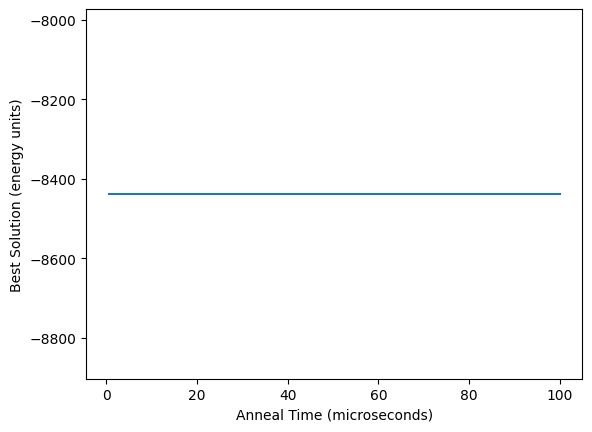

In [105]:
bqm = generators.ran_r(100,35)
time_list = []
# for t in [0.5,1.0,10,50,100,250,500,1000,1500,2000]:
# for t in [0.5,1.0,2,3,4,5,6,7,8,9,10,50,100,250,500,1000,1500,2000]:
for t in [0.5,1.0,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]:
    sample_set_best = min(sampler.sample(bqm,num_reads = 100, annealing_time = t).record['energy'])
    time_list.append((t,sample_set_best))
plt.plot([t[0] for t in time_list],[t[1] for t in time_list])
plt.xlabel('Anneal Time (microseconds)')
plt.ylabel('Best Solution (energy units)')
plt.show()

## Okay, what about average results?
These have been lackluster. Let's see if there's any interesting behavior with average result instead of best result per submission.

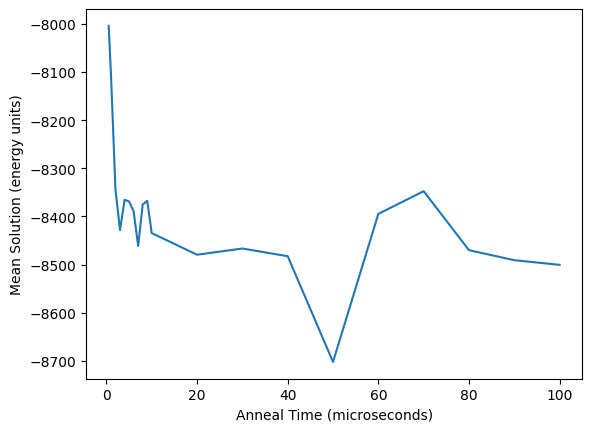

In [104]:
bqm = generators.ran_r(100,35)
time_list = []
# for t in [0.5,1.0,10,50,100,250,500,1000,1500,2000]:
for t in [0.5,1.0,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]:
    sset = sampler.sample(bqm,num_reads = 100, annealing_time = t)
    avg = sum(sset.record['num_occurrences'][i]* sset.record['energy'][i] for i in range(len(sset.record['energy'])))/sum(sset.record['num_occurrences'])
    time_list.append((t,avg))
plt.plot([t[0] for t in time_list],[t[1] for t in time_list])
plt.xlabel('Anneal Time (microseconds)')
plt.ylabel('Mean Solution (energy units)')
plt.show()

Well, I guess that's some behavior.
## What is happening?
Unfortunately this is basically what I expected. At really short anneal times the system is blasted through the process and "shatters" over the computational basis. That's why the lowest-energy is about the same at fast runtimes but the average is much higher. As the runtime increases we approach an adiabatic regime and the results start to be more consistent and lower.